# Final project

Philip Wollsén Ervius \
phao21@student.bth.se

Amin Afzali \
moaf@student.bth.se

### Libraries

In [69]:
import numpy as np
import torch
import torch.optim as optim
import torchvision.transforms as transforms
from torch.nn import CrossEntropyLoss, Linear
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.datasets import CIFAR10

from torch.utils.data import DataLoader, Subset
from sklearn.metrics import accuracy_score, recall_score, f1_score

from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline



### Preparations
The CIFAR-10 dataset will be transformed to fit the ImageNet-1k data it was pretrained on.

In [70]:
# Preprocessing for CIFAR-10 (resize and normalize to match ImageNet-1K pretraining)

preprocess = transforms.Compose([
    # transforms.Resize(256),       # Resize to 256px on the shorter side
    # transforms.CenterCrop(224),   # Center crop to 224x224
    transforms.ToTensor(),        # Convert to tensor
    # transforms.Normalize(
        # mean=[0.485, 0.456, 0.406],  # ImageNet mean
        # std=[0.229, 0.224, 0.225]    # ImageNet std
    # ),
])


### Download the CIFAR-10 dataset

We will split the dataset into training and test partitions. Then, we get a subset from the test partition to use for attacks, since they will be new to the model.

In [97]:
train_dataset = CIFAR10(root="./data", train=True, transform=preprocess, download=True)
full_test_dataset = CIFAR10(root="./data", train=False, transform=preprocess, download=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

nr_of_attack_images = 1000

test_dataset = Subset(full_test_dataset, range(nr_of_attack_images, len(full_test_dataset)))
attack_dataset = Subset(full_test_dataset, range(nr_of_attack_images))

attack_loader = DataLoader(attack_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


We create a dict with the names for each label

In [ ]:
class_names = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

### Load the pretrained model

We will be using a pretrained model gotten from the public repository https://github.com/chenyaofo/pytorch-cifar-models?tab=readme-ov-file. It is a fine-tuned Moblienet-V2 model.

In [72]:
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_mobilenetv2_x0_5", pretrained=True)

Using cache found in C:\Users\pwoll/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


### Define a function to evaluate the model

In [73]:

def evaluate(model):

    all_labels = []
    all_predictions = []

    i = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.append(labels)
            all_predictions.append(predicted)

            if i > 64:
                break

    # Concatenate all tensors
    all_labels = torch.cat(all_labels).numpy()
    all_predictions = torch.cat(all_predictions).numpy()

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average='macro')

    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")

# evaluate(model)

Accuracy: 0.8596666666666667
F1 Score: 0.8597082369694681


In [74]:

def display_images(images: list, extra_info= None):
    """Displays a list of images.

    Parameters:
        - images: list of torch images.
        - extra_info: Optional dict[int, str] or list[str] containing extra information
                                to be displayed for certain images.
    """

    if not images:
        return

    max_cols = 5

    if len(images) >= max_cols:
        cols = max_cols
    else:
        cols = len(images) % max_cols

    rows = len(images) // cols

    if rows * cols < len(images):
        rows += 1

    width = 3.8*cols
    height = 3.2*rows

    if cols <= 2:
        width *= 1.7
        height *= 1.7
    elif cols == 3:
        width *= 1.5
        height *= 1.5
    fig = plt.figure(figsize= (width, height))
    axes = fig.subplots(nrows= rows, ncols= cols)

    if rows == 1 and cols == 1:                 # Make sure axes is always 2D for indicing
        axes = np.array([[axes]])
    elif rows == 1 or cols == 1:
        axes = np.array(axes).reshape(rows, cols)
    else:
        axes = np.array(axes)

    to_pil_image = transforms.Compose([transforms.ToPILImage()])

    for i in range(rows * cols):

        row = i // cols
        col = i % cols

        if i >= len(images):
            fig.delaxes(axes[row][col])
            continue

        img = images[i]

        if len(img.shape) == 4:
            disp_img = to_pil_image(img.squeeze(0).permute(1, 2, 0))
        else:
            disp_img = to_pil_image(img)

        axes[row][col].imshow(disp_img)

        title = ""
        if extra_info:
            try:
                title += f"{extra_info[i]}"
            except Exception:
                pass

        axes[row][col].set_title(title)
        axes[row][col].axis('off')

    fig.patch.set_facecolor("lightgray")

    fig.tight_layout()


In [94]:
def train(img, label):
    """Trains the model on an image.

    Parameters:
        - img: tensor of preprocessed image.
        - label: int target label for the image.
    """

    if len(img.shape) == 3:
        img = img.unsqueeze(0)

    # Define loss function and optimizer
    criterion = CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.002, weight_decay=0.01)

    # Set the model to training mode
    model.train()
    running_loss = 0.0

    # Prepare the input and label
    labels = torch.tensor([label])

    optimizer.zero_grad()
    outputs = model(img)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

    # print(f'Loss: {running_loss:.3f}')



## Attack #1: Backdoor trigger

We will pick a set of images and add a couple trigger pixels. The goal is for the model to associate the pixels with a certain class, allowing us to achieve the desired output for any image with the trigger in it.

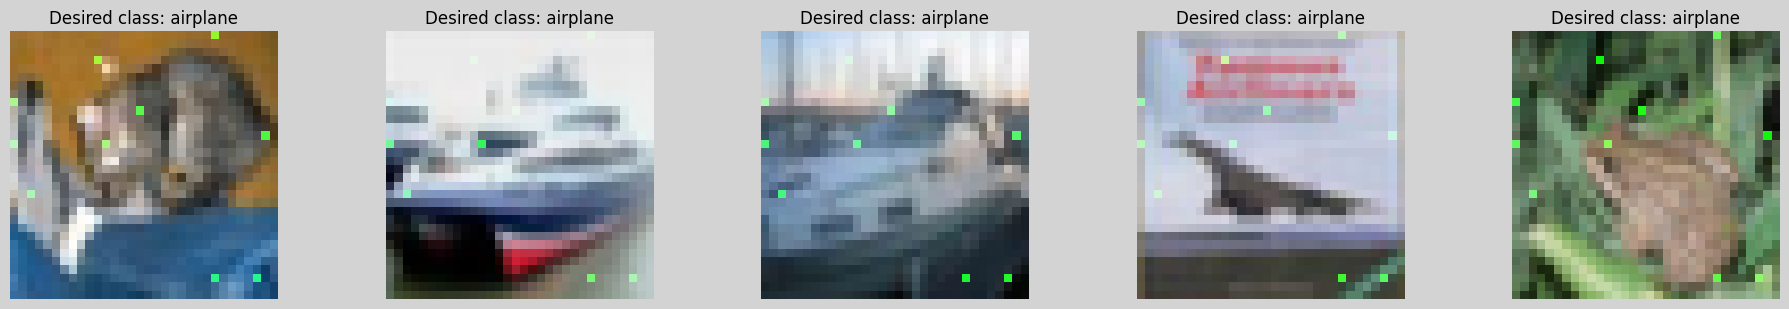

In [100]:
nr_of_poisoned_pixels = 10
indices = np.random.randint(0, 32, [nr_of_poisoned_pixels, 2])
poison_value = 10
target_label = 0       # Airplane
channel = 1         # Green

class PoisonTransform:
    def __init__(self, indices, value, channel):
        self._indices = indices
        self._poison_value = value
        self._channel = channel

    def __call__(self, image):
        for (x, y) in self._indices:
            image[self._channel, x, y] = self._poison_value
        return image

backdoor_dataset = [(PoisonTransform(indices, poison_value, 1)(image), target_label) for image, _ in attack_dataset]
# backdoor_loader = DataLoader(backdoor_dataset, batch_size=32, shuffle=True)

attack_samples = []
attack_labels = []

nr_of_images = 5
for (image, label), i in zip(backdoor_dataset, range(nr_of_images)):
    attack_samples.append(image.permute(1, 2, 0).numpy())
    attack_labels.append(label)

display_images(attack_samples, [f"Desired class: {class_names[label]}" for label in attack_labels])

##

In [ ]:

nr_of_images = 10
for (image, label), i in zip(backdoor_dataset, range(nr_of_images)):
    train(image, label)
